# Understanding and Predicting Property Maintenance Fines

This project is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 
___

Create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

# Summary
* [1. Data Information](#1.)
    * [1.1 Missing Values](#1.1)
    * [1.2 Numeric Features](#1.2)
    * [1.3 Categorical Features](#1.3)
* [2. Data Visualization](#2.)
    * [2.1 Owed Amount](#2.1)
    * [2.2 Agency Name](#2.2)
    * [2.3 Disposition](#2.3)
    * [2.4 Ticket Issued Month](#2.4)
    * [2.5 Ticket Issued Semester](#2.5)
    * [2.6 Hearing Month](#2.6)    
* [3. Predictive Model](#3.)
    * [3.1 Data Preprocessing and Feature Selection](#3.1)
    * [3.2 Models](#3.2)
    * [3.3 Hyperparameter Tuning](#3.3)
    * [3.4 Save Model](#3.4)
* [4. Conclusion](#4.)
    * [4.1 Payment](#4.1)
    * [4.2 Compliance](#4.2)
    * [4.3 Model](#4.3)

# Import the python libraries

In [1]:
# data analysis
import numpy as np
import pandas as pd

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# machine learning models
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# machine learning metrics
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# other
import time
import joblib as jb
from pprint import pprint

# 1. Data information <a class='anchor' id='1.'></a>

In [11]:
# Remove the limit of columns to be displayed in the notebook
pd.set_option('display.max_columns', None)

In [12]:
df_train = pd.read_csv('csv/train.csv', encoding='ISO-8859-1', low_memory=False)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ticket_id                   250306 non-null  int64  
 1   agency_name                 250306 non-null  object 
 2   inspector_name              250306 non-null  object 
 3   violator_name               250272 non-null  object 
 4   violation_street_number     250306 non-null  float64
 5   violation_street_name       250306 non-null  object 
 6   violation_zip_code          0 non-null       float64
 7   mailing_address_str_number  246704 non-null  float64
 8   mailing_address_str_name    250302 non-null  object 
 9   city                        250306 non-null  object 
 10  state                       250213 non-null  object 
 11  zip_code                    250305 non-null  object 
 12  non_us_str_code             3 non-null       object 
 13  country       

In [13]:
df_train[(df_train['state'] == 'MI') & (df_train['city'].str.lower().str.startswith('det'))]['city'].unique()

array(['Detroit', 'DETROIT', 'Det', 'DEt', 'detroit', 'det', 'Det.',
       'DETRIT', 'DETOIT', 'detroitt', 'detriot', 'DETRIUT', 'DET',
       'DETROIT`', 'DETROTI', 'DETROITdetroit', 'DETROIOT', 'DETRJOIT',
       'DETROT', 'DETRPOT', 'DETRIOT', 'dETROIT', 'Detrofit', 'DETRROIT',
       'DETROIRT', 'DETROIT,', 'DETROITM', 'DETEROIT', 'Detroi',
       'Detroti', 'detrot', 'DETROITI', 'DETROIYT', 'Detroitf', 'det.',
       'DETROOIT', 'DETROIIT', 'DETORIT', 'detrorit', 'DETROIT1',
       'DETROITQ', 'Detrroit', 'DETEOIT', 'DETROIR', 'detrtoit',
       'Detriot', 'detroit`', 'DET.', 'deT', 'DETREOIT', 'DETAROIT',
       'DETTROIT', 'DETROIS', 'Detrot', 'DETROITT', 'Detro;it', 'DETRTOI',
       'DETROI', 'DEtroit', 'DETR4OIT', 'det48234', 'DET,', 'DETRIOIT',
       'Detorit', 'DETROPIT', 'DETROIT, MI. 48206', 'DETROUIT',
       'DETROIT, MI.', 'DETROKT', 'DETROITF', 'Detroir', 'DETOUR VILLAGE',
       'DETTROITM', 'DET ,', 'detoit', 'Detroit`', 'DET ROIT',
       'DET., MI.', 'DET.,', 'D

Analysing the unique cities from Michigan state that starts with 'det', the distinct city 'DETOUR VILLAGE' was identified.
<br>
First I removed all entries that are not from Detroit and the person was not fined (judgment_amount = 0)

In [14]:
df_train = df_train[(df_train['state'] == 'MI') & (df_train['city'].str.lower().str.startswith('det')) & (~df_train['city'].isin(['DETOUR VILLAGE'])) & (df_train['judgment_amount'] != 0)].set_index('ticket_id')
df_train['city'] = 'Detroit'

print(f'Number of Examples = {df_train.shape[0]}')
print(f'X Shape = {df_train.shape}')
print(f'y Shape = {df_train["compliance"].shape[0]}\n')

Number of Examples = 97584
X Shape = (97584, 33)
y Shape = 97584



## 1.1 Missing values <a class='anchor' id='1.1'></a>

In [15]:
print(f'Only features contained missing value in Training Dataset')
temp = df_train.isnull().sum()
print(temp.loc[temp!=0], '\n')

Only features contained missing value in Training Dataset
violator_name                    14
violation_zip_code            97584
mailing_address_str_number      715
non_us_str_code               97584
hearing_date                    116
payment_date                  74564
collection_status             77949
grafitti_status               97584
dtype: int64 



Drop the columns that most of rows are missing values, except for the payment_date column that may contain some useful information about the problem

In [16]:
null_features = df_train.isnull().sum()
all_null = df_train.columns[list(null_features == df_train.shape[0])]
df_train.drop(all_null, axis=1, inplace=True)
df_train.drop('collection_status', axis=1, inplace=True)

Drop the rows that has missing values for the remaining features, since they represent a really small portion of the dataset

In [17]:
null_features = df_train.isnull().sum()
null_2000 = df_train.columns[list((null_features < 2000) & (null_features != 0))]
df_train.drop(df_train[df_train[null_2000].isnull().any(axis=1)].index, inplace=True)

In [18]:
print(f'Only features contained missing value in Training Dataset')
temp = df_train.isnull().sum()
print(temp.loc[temp!=0], '\n')

Only features contained missing value in Training Dataset
payment_date    73935
dtype: int64 



In [19]:
print(f'Number of Examples = {df_train.shape[0]}')
print(f'X Shape = {df_train.shape}')
print(f'y Shape = {df_train["compliance"].shape[0]}\n')

Number of Examples = 96745
X Shape = (96745, 29)
y Shape = 96745



839 entries were removed from the training dataset<br>

## 1.2 Numeric Features <a class='anchor' id='1.2'></a>

In [20]:
df_train.describe()

,violation_street_number,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance
count,9.674500e+04,9.674500e+04,96745.000000,96745.0,96745.0,96745.000000,96745.000000,96745.0,96745.000000,96745.000000,96745.000000,96745.000000
mean,1.031852e+04,7.865159e+03,324.110962,20.0,10.0,30.609737,0.139418,0.0,384.720699,57.096167,327.485197,0.069668
std,4.626965e+04,2.284441e+04,601.721250,0.0,0.0,60.407631,2.659109,0.0,661.510687,163.511476,666.774246,0.254587
min,0.000000e+00,1.000000e+00,25.000000,20.0,10.0,0.000000,0.000000,0.0,55.000000,0.000000,-1575.000000,0.000000
25%,4.314000e+03,8.320000e+02,200.000000,20.0,10.0,10.000000,0.000000,0.0,230.000000,0.000000,85.000000,0.000000
50%,9.534000e+03,2.668000e+03,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000
75%,1.542500e+04,1.354800e+04,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000
max,1.415411e+07,3.511219e+06,10000.000000,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,11030.000000,11030.000000,1.000000


In [21]:
print('There are {} numeric features in the training dataset'.format(len(df_train.describe().columns)))

There are 12 numeric features in the training dataset


In [22]:
df_train[df_train['discount_amount'] != 0][['discount_amount', 'judgment_amount', 'payment_amount', 'balance_due']].head()

,discount_amount,judgment_amount,payment_amount,balance_due
ticket_id,,,,
18653,25.0,280.0,255.0,0.0
18915,25.0,280.0,250.0,5.0
20851,30.0,330.0,260.0,40.0
22450,25.0,280.0,280.0,-25.0
22634,10.0,130.0,120.0,0.0


### Observations

* The 'judgment_amount' column does not include the value from the 'discount_amount' column
* We'll create a new column 'owed_amount' to get the result from the substraction of the 'judgment_amount' by the 'discount_amount'
* The 'mailing_address_str_number' and 'violation_street_number' columns are numeric categorical features

### Correlation hypothesis
* The 'compliance' may be related to the 'owed_amount' by the person

In [23]:
df_train['owed_amount'] = df_train['judgment_amount'] - df_train['discount_amount']
df_train[df_train['discount_amount'] != 0][['discount_amount', 'judgment_amount', 'owed_amount', 'payment_amount', 'balance_due']].head()

,discount_amount,judgment_amount,owed_amount,payment_amount,balance_due
ticket_id,,,,,
18653,25.0,280.0,255.0,255.0,0.0
18915,25.0,280.0,255.0,250.0,5.0
20851,30.0,330.0,300.0,260.0,40.0
22450,25.0,280.0,255.0,280.0,-25.0
22634,10.0,130.0,120.0,120.0,0.0


In [24]:
df_train.describe()

,violation_street_number,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance,owed_amount
count,9.674500e+04,9.674500e+04,96745.000000,96745.0,96745.0,96745.000000,96745.000000,96745.0,96745.000000,96745.000000,96745.000000,96745.000000,96745.000000
mean,1.031852e+04,7.865159e+03,324.110962,20.0,10.0,30.609737,0.139418,0.0,384.720699,57.096167,327.485197,0.069668,384.581281
std,4.626965e+04,2.284441e+04,601.721250,0.0,0.0,60.407631,2.659109,0.0,661.510687,163.511476,666.774246,0.254587,661.483612
min,0.000000e+00,1.000000e+00,25.000000,20.0,10.0,0.000000,0.000000,0.0,55.000000,0.000000,-1575.000000,0.000000,52.000000
25%,4.314000e+03,8.320000e+02,200.000000,20.0,10.0,10.000000,0.000000,0.0,230.000000,0.000000,85.000000,0.000000,230.000000
50%,9.534000e+03,2.668000e+03,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000,305.000000
75%,1.542500e+04,1.354800e+04,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000,305.000000
max,1.415411e+07,3.511219e+06,10000.000000,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,11030.000000,11030.000000,1.000000,11030.000000


Since the mean value of the owed_amount column is 268.6, 75% of the values are lower than 305 and the standard deviation is 626.8, we can infer that there are a lot of outliers in this column.

In [25]:
bands_dict = {}
band_columns = ['owed_amount']
for column in band_columns:
    band_name = column + '_band'
    if column == 'owed_amount':
        df_train[band_name] = pd.cut(df_train[column].drop(df_train[df_train[column] > 400].index), 5)
    else:
        df_train[band_name] = pd.cut(df_train[column], 5)
    bands = df_train.groupby(band_name).agg({'compliance':len})
    bands_dict[column] = bands
    df_train[band_name] = df_train[band_name].astype(str)
    for number, band in enumerate(bands.index):
        bands_dict[column].iloc[number] = number
        df_train.loc[df_train[band_name] == str(band), band_name] = number
    if column == 'owed_amount':
        df_train[band_name] = df_train[band_name].replace('nan', 4)
    df_train[band_name] = df_train[band_name].astype(int)

df_train.head()

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,compliance_detail,compliance,owed_amount,owed_amount_band
ticket_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,2959.0,Martin Luther King,Detroit,MI,48208,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,compliant by late payment within 1 month,1.0,855.0,4
18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,8228.0,Mt. Elliott,Detroit,MI,48211,USA,2004-06-16 12:30:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,140.0,1
18733,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,8228.0,Mt. Elliott,Detroit,MI,48211,USA,2004-06-16 12:25:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,140.0,1
28204,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Inc, Nanno",15307.0,SEVEN MILE,1537.0,E. Seven Mile,Detroit,MI,48205,USA,2004-07-12 13:30:00,2005-05-31 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,855.0,4
18743,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Gardner Resale, GAR",9100.0,VAN DYKE,91.0,Van Dyke,Detroit,MI,48213,USA,2004-07-28 12:15:00,2005-02-22 15:00:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,855.0,4


## 1.3 Categorical Features <a class='anchor' id='1.3'></a>

In [26]:
df_train.describe(include=['O'])

,agency_name,inspector_name,violator_name,violation_street_name,mailing_address_str_name,city,state,zip_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,payment_date,payment_status,compliance_detail
count,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,22810,96745,96745
unique,4,156,54958,1626,8258,1,1,493,1,49309,5667,166,182,3,2164,3,6
top,"Buildings, Safety Engineering & Env Department","Morris, John","APARTMENTS, CARLTON",SEVEN MILE,PO BOX,Detroit,MI,48227,USA,2008-01-22 09:00:00,2005-12-20 09:00:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,2007-05-25 00:00:00,NO PAYMENT APPLIED,non-compliant by no payment
freq,59860,8023,102,1570,1939,96745,96745,7219,96745,49,395,41242,41242,83817,93,73935,79062


### Observations
* The year and month from the 'ticket_issued_date' column can be extracted to build 2 new columns 'ticket_issued_year' and 'ticket_issued_month'
* The year and month from the 'hearing_date' can be extracted to build 2 new columns 'hearing_year' and 'hearing_month'
* The year and month from the 'payment_date' column can be extracted to build 2 new columns 'payment_year' and 'payment_month'

### Correlation hypothesis
* The 'compliance' may be related to the 'agency_name' that issued the ticket
* The 'compliance' may be related to the violation location ('violation_street_number' and 'violation_street_name' column can be used)
* The 'compliance' may be related to the violator's address ('mailing_address_str_number', 'mailing_address_str_name' and 'zip_code' columns can be used)
* The 'compliance' may be related to the 'ticket_issued_month' column
* The 'compliance' may be related to the 'hearing_month' column
* The 'compliance' may be related to the 'violation_code' column
* The 'compliance' may be related to the 'disposition' column

In [27]:
df_train = pd.concat([df_train, df_train['ticket_issued_date'].str.extract(r'(?P<ticket_issued_year>\d{4})-(?P<ticket_issued_month>\d{2})')], axis=1)
df_train['ticket_issued_semester'] = [1 if x <= 6 else 2 for x in df_train['ticket_issued_month'].astype(int)]
df_train = pd.concat([df_train, df_train['hearing_date'].str.extract(r'(?P<hearing_year>\d{4})-(?P<hearing_month>\d{2})')], axis=1)
df_train = pd.concat([df_train, df_train['payment_date'].str.extract(r'(?P<payment_year>\d{4})-(?P<payment_month>\d{2})')], axis=1)

In [28]:
df_train[['ticket_issued_date', 'ticket_issued_year', 'ticket_issued_month', 'ticket_issued_semester', 'hearing_date', 'hearing_year', 'hearing_month', 'payment_date', 'payment_year', 'payment_month']].head()

,ticket_issued_date,ticket_issued_year,ticket_issued_month,ticket_issued_semester,hearing_date,hearing_year,hearing_month,payment_date,payment_year,payment_month
ticket_id,,,,,,,,,,
27586,2004-04-23 12:30:00,2004,04,1,2005-05-06 13:30:00,2005,05,2005-06-02 00:00:00,2005,06
18735,2004-06-16 12:30:00,2004,06,1,2005-02-22 15:00:00,2005,02,NaN,NaN,NaN
18733,2004-06-16 12:25:00,2004,06,1,2005-02-22 15:00:00,2005,02,NaN,NaN,NaN
28204,2004-07-12 13:30:00,2004,07,2,2005-05-31 13:30:00,2005,05,NaN,NaN,NaN
18743,2004-07-28 12:15:00,2004,07,2,2005-02-22 15:00:00,2005,02,NaN,NaN,NaN


In [29]:
df_train[['agency_name', 'compliance']].groupby(['agency_name'], as_index=False).mean().sort_values(by='compliance', ascending=False).set_index('agency_name').apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))

,compliance
agency_name,
Detroit Police Department,12.05%
Department of Public Works,8.46%
"Buildings, Safety Engineering & Env Department",6.06%
Health Department,5.50%


Only consider violation_street_name that had 100 occurrences or more

In [30]:
df_train.loc[df_train.violation_street_name.isin(df_train[df_train['violation_street_name'].map(df_train['violation_street_name'].value_counts() < 100)]['violation_street_name'].value_counts().index), 'violation_street_name'] = 'Rare'
df_train[['violation_street_name', 'compliance']].groupby(['violation_street_name'], as_index=False).mean().sort_values(by='compliance', ascending=False).set_index('violation_street_name').apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))

,compliance
violation_street_name,
LAWTON,18.55%
MICHIGAN AVE,17.15%
SECOND,16.55%
GRATIOT,14.88%
MT ELLIOTT,14.50%
...,...
COLUMBUS,0.66%
LARNED,0.66%
LAKEVIEW,0.00%


Only consider violation_code that had 100 occurrences or more

In [31]:
df_train.loc[df_train.violation_code.isin(df_train[df_train['violation_code'].map(df_train['violation_code'].value_counts() < 100)]['violation_code'].value_counts().index), 'violation_code'] = 'Rare'
df_train[['violation_code', 'compliance']].groupby(['violation_code'], as_index=False).mean().sort_values(by='compliance', ascending=False).set_index('violation_code').apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))

,compliance
violation_code,
22-2-61,24.22%
61-81.0100/32.0066,15.96%
9-1-103(C),12.90%
22-2-43,12.44%
22-2-45,12.21%
9-1-110(a),11.90%
22-2-21(b),11.76%
9-1-209,11.68%
61-5-21,9.93%


Only consider zip_code that had 100 occurrences or more

In [32]:
df_train.loc[df_train.zip_code.isin(df_train[df_train['zip_code'].map(df_train['zip_code'].value_counts() < 100)]['zip_code'].value_counts().index), 'zip_code'] = 'Rare'
df_train[['zip_code', 'compliance']].groupby(['zip_code'], as_index=False).mean().sort_values(by='compliance', ascending=False).set_index('zip_code').apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))

,compliance
zip_code,
48216,14.51%
48209,11.84%
48237,10.91%
48201,10.23%
48226,9.41%
48207,9.28%
48236,8.92%
48239,8.79%
48212,8.53%


In [33]:
df_train[['disposition', 'compliance']].groupby(['disposition'], as_index=False).mean().sort_values(by='compliance', ascending=False).set_index('disposition').apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))

,compliance
disposition,
Responsible by Determination,29.05%
Responsible by Admission,28.90%
Responsible by Default,3.57%


We can analyse the data in order to be aware of the amount of compliant and non-compliant people in Detroit and understand how this problem is actually affecting the city

In [34]:
total_compliant_people = df_train[df_train['compliance'] == 1]['compliance'].value_counts().sum()
total_non_compliant_people = df_train[df_train['compliance'] == 0]['compliance'].value_counts().sum()
total_people = total_compliant_people + total_non_compliant_people
print('Percentage of compliant people: {:.2f}%'.format(total_compliant_people/total_people*100))
print('Percentage of non-compliant people: {:.2f}%'.format(total_non_compliant_people/total_people*100))

Percentage of compliant people: 6.97%
Percentage of non-compliant people: 93.03%


In [35]:
print('Total paid amount: ${0:,.2f}'.format(df_train['payment_amount'].sum()))

Total paid amount: $5,523,768.70


In [36]:
df_train.groupby('payment_year').agg({'payment_amount':np.sum}).apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))

,payment_amount
payment_year,
2005,"$ 593,583.00"
2006,"$ 820,345.50"
2007,"$ 903,144.40"
2008,"$ 864,181.30"
2009,"$ 667,084.30"
2010,"$ 697,493.00"
2011,"$ 384,442.00"
2012,"$ 133,921.10"
2013,"$ 107,637.20"


We can see that the average payment amount per year decreased in the last years

In [37]:
df_train.groupby('payment_month').agg({'payment_amount':np.sum}).apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x))).sort_values(by='payment_amount', ascending=False)

,payment_amount
payment_month,
05,"$ 683,612.50"
06,"$ 666,660.60"
03,"$ 589,411.30"
04,"$ 498,545.40"
08,"$ 454,372.00"
10,"$ 428,112.60"
07,"$ 406,477.30"
09,"$ 405,066.90"
02,"$ 395,735.80"


* Months that contains the highest accumulated amounts of payment: March to June
* Months that contains the lowest accumulated amounts of payment: November to February
* Remainders or charges of late or possibly late tickets could be preferably be made from March to June

In [38]:
print('Total pending payment amount: ${0:,.2f}'.format(df_train['balance_due'].sum()))

Total pending payment amount: $31,682,555.40


In [39]:
ticket_issued_year_analysis = df_train.groupby('ticket_issued_year').agg({'owed_amount':np.sum, 'balance_due':np.sum, 'compliance':np.mean})
ticket_issued_year_analysis['paid_amount'] = ticket_issued_year_analysis['owed_amount'] - ticket_issued_year_analysis['balance_due']
ticket_issued_year_analysis['paid_percent'] = ticket_issued_year_analysis['paid_amount']/ticket_issued_year_analysis['owed_amount']
print('The average owed amount per year, since 2005, is $ {:,.2f}'.format(ticket_issued_year_analysis.iloc[2:]['owed_amount'].mean()))
print('The average pending payment amount per year, since 2005, is $ {:,.2f}'.format(ticket_issued_year_analysis.iloc[2:]['balance_due'].mean()))
print('The average payment percentage per year, since 2005, is {:.2f}%'.format(ticket_issued_year_analysis.iloc[2:]['paid_percent'].mean()*100))
currency_columns = ['owed_amount', 'balance_due', 'paid_amount']
percent_columns = ['compliance', 'paid_percent']
ticket_issued_year_analysis[currency_columns] = ticket_issued_year_analysis[currency_columns].apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))
ticket_issued_year_analysis[percent_columns] = ticket_issued_year_analysis[percent_columns].apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))
ticket_issued_year_analysis

The average owed amount per year, since 2005, is $ 5,314,118.71
The average pending payment amount per year, since 2005, is $ 4,525,170.77
The average payment percentage per year, since 2005, is 14.72%


,owed_amount,balance_due,compliance,paid_amount,paid_percent
ticket_issued_year,,,,,
1988,$ 85.00,$ 0.00,100.00%,$ 85.00,100.00%
2004,"$ 7,400.00","$ 6,360.00",25.00%,"$ 1,040.00",14.05%
2005,"$ 5,191,939.00","$ 3,934,927.60",7.61%,"$ 1,257,011.40",24.21%
2006,"$ 7,626,712.00","$ 6,406,304.30",7.23%,"$ 1,220,407.70",16.00%
2007,"$ 7,424,822.50","$ 6,583,295.40",7.07%,"$ 841,527.10",11.33%
2008,"$ 7,084,717.50","$ 6,125,964.90",6.49%,"$ 958,752.60",13.53%
2009,"$ 5,178,177.50","$ 4,524,650.90",7.37%,"$ 653,526.60",12.62%
2010,"$ 2,693,192.50","$ 2,361,414.20",4.56%,"$ 331,778.30",12.32%
2011,"$ 1,999,270.00","$ 1,739,638.10",7.92%,"$ 259,631.90",12.99%


In [40]:
ticket_issued_month_analysis = df_train.groupby('ticket_issued_month').agg({'owed_amount':np.sum, 'balance_due':np.sum, 'compliance':np.mean})
ticket_issued_month_analysis['paid_amount'] = ticket_issued_month_analysis['owed_amount'] - ticket_issued_month_analysis['balance_due']
ticket_issued_month_analysis['paid_percent'] = ticket_issued_month_analysis['paid_amount']/ticket_issued_month_analysis['owed_amount']
currency_columns = ['owed_amount', 'balance_due', 'paid_amount']
percent_columns = ['compliance', 'paid_percent']
ticket_issued_month_analysis[currency_columns] = ticket_issued_month_analysis[currency_columns].apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))
ticket_issued_month_analysis[percent_columns] = ticket_issued_month_analysis[percent_columns].apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))
ticket_issued_month_analysis

,owed_amount,balance_due,compliance,paid_amount,paid_percent
ticket_issued_month,,,,,
01,"$ 3,190,885.00","$ 2,675,823.20",8.84%,"$ 515,061.80",16.14%
02,"$ 3,204,078.50","$ 2,617,590.60",8.91%,"$ 586,487.90",18.30%
03,"$ 3,454,890.00","$ 2,820,192.50",9.24%,"$ 634,697.50",18.37%
04,"$ 3,394,797.50","$ 2,902,730.60",7.77%,"$ 492,066.90",14.49%
05,"$ 3,225,140.50","$ 2,775,016.90",7.56%,"$ 450,123.60",13.96%
06,"$ 3,105,892.50","$ 2,631,060.20",5.93%,"$ 474,832.30",15.29%
07,"$ 2,724,712.50","$ 2,309,026.60",5.77%,"$ 415,685.90",15.26%
08,"$ 3,377,980.00","$ 2,947,101.10",5.23%,"$ 430,878.90",12.76%
09,"$ 3,275,652.50","$ 2,820,800.00",5.67%,"$ 454,852.50",13.89%


In [41]:
ticket_issued_month_analysis = df_train.groupby('ticket_issued_month').agg({'owed_amount':np.sum, 'balance_due':np.sum, 'compliance':np.mean})
ticket_issued_month_analysis['ticket_issued_semester'] = np.where(ticket_issued_month_analysis.index.astype('int') <= 6, 1, 2)
ticket_issued_month_analysis = ticket_issued_month_analysis.groupby('ticket_issued_semester').agg({'owed_amount':np.sum, 'balance_due':np.sum, 'compliance':np.mean})
ticket_issued_month_analysis['paid_amount'] = ticket_issued_month_analysis['owed_amount'] - ticket_issued_month_analysis['balance_due']
ticket_issued_month_analysis['paid_percent'] = ticket_issued_month_analysis['paid_amount']/ticket_issued_month_analysis['owed_amount']
currency_columns = ['owed_amount', 'balance_due', 'paid_amount']
percent_columns = ['compliance', 'paid_percent']
ticket_issued_month_analysis[currency_columns] = ticket_issued_month_analysis[currency_columns].apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))
ticket_issued_month_analysis[percent_columns] = ticket_issued_month_analysis[percent_columns].apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))
ticket_issued_month_analysis

,owed_amount,balance_due,compliance,paid_amount,paid_percent
ticket_issued_semester,,,,,
1,"$ 19,575,684.00","$ 16,422,414.00",8.04%,"$ 3,153,270.00",16.11%
2,"$ 17,630,632.00","$ 15,260,141.40",5.95%,"$ 2,370,490.60",13.45%


* The payment_amount and compliance percentage is higher in tickets issued the first semester
* The city hall can be aware of this tendency and build some strategies to first improve the compliance of these tickets

In [42]:
df_train['compliance_detail'].value_counts()

non-compliant by no payment                        79062
non-compliant by late payment more than 1 month    10943
compliant by late payment within 1 month            3691
compliant by on-time payment                        2416
compliant by early payment                           587
compliant by payment on unknown date                  46
Name: compliance_detail, dtype: int64

In [43]:
df_train['compliance_detail'].value_counts(normalize=True).apply(lambda x: '{:.2f}%'.format(x*100))

non-compliant by no payment                        81.72%
non-compliant by late payment more than 1 month    11.31%
compliant by late payment within 1 month            3.82%
compliant by on-time payment                        2.50%
compliant by early payment                          0.61%
compliant by payment on unknown date                0.05%
Name: compliance_detail, dtype: object

In [44]:
df_train[df_train['compliance'] == 0]['compliance_detail'].value_counts(normalize=True).apply(lambda x: '{:.2f}%'.format(x*100))

non-compliant by no payment                        87.84%
non-compliant by late payment more than 1 month    12.16%
Name: compliance_detail, dtype: object

In [45]:
compliance_detail_analysis = df_train.groupby('compliance_detail').agg({'owed_amount':np.sum, 'payment_amount':np.sum, 'balance_due':np.sum})
compliance_detail_analysis['paid_percent'] = compliance_detail_analysis['payment_amount']/compliance_detail_analysis['owed_amount']
currency_columns = ['owed_amount', 'balance_due', 'payment_amount']
percent_columns = ['paid_percent']
compliance_detail_analysis[currency_columns] = compliance_detail_analysis[currency_columns].apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))
compliance_detail_analysis[percent_columns] = compliance_detail_analysis[percent_columns].apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))
compliance_detail_analysis

,owed_amount,payment_amount,balance_due,paid_percent
compliance_detail,,,,
compliant by early payment,"$ 130,867.00","$ 122,559.00","$ 8,316.00",93.65%
compliant by late payment within 1 month,"$ 1,003,852.00","$ 919,390.80","$ 84,461.20",91.59%
compliant by on-time payment,"$ 581,925.00","$ 581,885.00",$ 40.00,99.99%
compliant by payment on unknown date,"$ 15,577.50","$ 15,582.50",$ -5.00,100.03%
non-compliant by late payment more than 1 month,"$ 3,275,719.50","$ 2,896,593.80","$ 379,125.70",88.43%
non-compliant by no payment,"$ 32,198,375.00","$ 987,757.60","$ 31,210,617.50",3.07%


In [46]:
compliance_analysis = df_train.groupby('compliance').agg({'owed_amount':np.sum, 'payment_amount':np.sum, 'balance_due':np.sum})
compliance_analysis['paid_percent'] = compliance_analysis['payment_amount']/compliance_analysis['owed_amount']
currency_columns = ['owed_amount', 'balance_due', 'payment_amount']
percent_columns = ['paid_percent']
compliance_analysis[currency_columns] = compliance_analysis[currency_columns].apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))
compliance_analysis[percent_columns] = compliance_analysis[percent_columns].apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))
compliance_analysis

,owed_amount,payment_amount,balance_due,paid_percent
compliance,,,,
0.0,"$ 35,474,094.50","$ 3,884,351.40","$ 31,589,743.20",10.95%
1.0,"$ 1,732,221.50","$ 1,639,417.30","$ 92,812.20",94.64%


* Almost 88% of the non-compliant cases are from people who didn't pay the blight ticket
* There is more than 31 million US dollars that are pending from payment of non-compliant people

# 2. Data Visualization <a class='anchor' id='2.'></a>

In [47]:
def add_value_labels(ax, orientation, xspace=0, yspace=0, percentage=False):
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        if orientation == 'v':
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2
            label = rect.get_height()
        elif orientation == 'h':
            y_value = rect.get_y() + rect.get_height() / 4
            x_value = rect.get_width()
            label = rect.get_width()            

        # Vertical alignment for positive values
        va = 'bottom'

        # Define the label format
        if percentage==True:
            label = "{:.1%}".format(label)
        else:
            label = "{:,.0f}".format(label)

        # Create annotation
        ax.annotate(
            label,                     
            (x_value, y_value),        
            xytext=(xspace, yspace),   
            textcoords="offset points",
            ha='center',               
            va=va)                     

In [48]:
def plot_percent_category(df, field, xvalues, compliance=False, xticks=None, legend_loc='best', xspace=0, yspace=0, legend_pos=None):
    total = []
    non_compliant = []
    compliant = []
    
    total_values = df[field].value_counts().sort_index()
    non_compliant_values = df[df['compliance'] == 0][field].value_counts()
    compliant_values = df[df['compliance'] == 1][field].value_counts()
    
    if xticks == None:
        xticks = xvalues
    
    for value in xvalues:
        if value in total_values.index:
            total.append(total_values[value])
        else:
            total.append(0)
            
        if value in non_compliant_values.index:
            non_compliant.append(non_compliant_values[value])
        else:
            non_compliant.append(0)
        
        if value in compliant_values.index:
            compliant.append(compliant_values[value])
        else:
            compliant.append(0)


    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    w = 1
    folds = np.linspace(5,len(xvalues)*5, len(xvalues))
    
    if compliance == False:
        image = 'images/' + field + '_Bar'
        title = 'Customer percentage distribution by {} and compliance'.format(field)
        ax.bar([element - w/2 for element in folds], [number if sum(total) == 0 else number / sum(total) for number in non_compliant], width=w)
        ax.bar([element + w/2 for element in folds], [number if sum(total) == 0 else number / sum(total) for number in compliant], width=w)
    else:
        image = 'images/' + field + '_Bar_Compliance'
        title = 'Compliance percentage by {}'.format(field)
        ax.bar([element - w/2 for element in folds], [number if total == 0 else number / total for number, total in zip(non_compliant, total)], width=w)
        ax.bar([element + w/2 for element in folds], [number if total == 0 else number / total for number, total in zip(compliant, total)], width=w)
        
    add_value_labels(ax, orientation='v', yspace=5, percentage=True, xspace=xspace)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    plt.xticks(folds, xticks)
    plt.title(title, fontweight='bold',size=15)
    legend = ['Non-compliant', 'Compliant']
    if legend_pos == None:
        plt.legend(legend, framealpha=0, loc=legend_loc)
    else:
        plt.legend(legend, framealpha=0, bbox_to_anchor=legend_pos)
    #plt.savefig(image)
    plt.show()

In [49]:
def plot_pie(df, field, legend, compliance=False, order=None, size=(16,8), pct=0.75, startangle=0, legend_pos=(0.2,0.2), pct_pos={}):
    # Define if only the respondent customers will be considered
    if compliance == False:
        image = 'images/' + field + '_Pie'
        entries = df[field].value_counts()
        title = 'Customers percentage distribution by {}'.format(field)
    else:
        image = 'images/' + field + '_Pie_Compliance'
        entries = df[df['compliance'] == 1][field].value_counts()
        title = 'Compliant customers percentage distribution by {}'.format(field)
    
    legend_copy = legend.copy()
    
    # Define if there is an exact order of values to be plotted
    if order == None:
        compliant = list(entries)
    else:
        compliant = []
        for value in order[::-1]:
            if value in entries.index:
                compliant.append(entries[value])
            else:
                legend_copy.pop(value)
        compliant = compliant[::-1]
    
    # Set the figure parameters
    sns.set(style='white',font_scale=1.1, rc={'figure.figsize':size})

    # Create pie chart
    ax = plt.subplot(1, 2, 1)
    plt.title(title, fontweight='bold',size=15)
    _, _, autopcts = ax.pie(compliant, autopct='%1.1f%%', pctdistance=pct, startangle=startangle)
    plt.setp(autopcts, **{'fontsize':15, 'fontweight': 'bold'})
    
    # Adjust pct positions
    for key, value in pct_pos.items():
        pct = autopcts[key]
        d=1
        xi,yi = pct.get_position()
        ri = np.sqrt(xi**2+yi**2)
        phi = np.arctan2(yi,xi)
        x = d*ri*np.cos(phi)+value[0]
        y = d*ri*np.sin(phi)+value[1]
        pct.set_position((x,y))

    plt.legend(legend_copy, bbox_to_anchor=legend_pos, framealpha=0.0, prop={'size': 12})
    #plt.savefig(image)
    plt.show()

## 2.1 Owed Amount <a class='anchor' id='2.1'></a>

Bar plot with interval percentages

In [50]:
bands_dict['owed_amount']

,compliance
owed_amount_band,
"(51.692, 113.6]",0.0
"(113.6, 175.2]",1.0
"(175.2, 236.8]",2.0
"(236.8, 298.4]",3.0
"(298.4, 360.0]",4.0


In [51]:
df_train['owed_amount_band'].value_counts().sort_index()

0    12678
1    10878
2      728
3    10828
4    61633
Name: owed_amount_band, dtype: int64

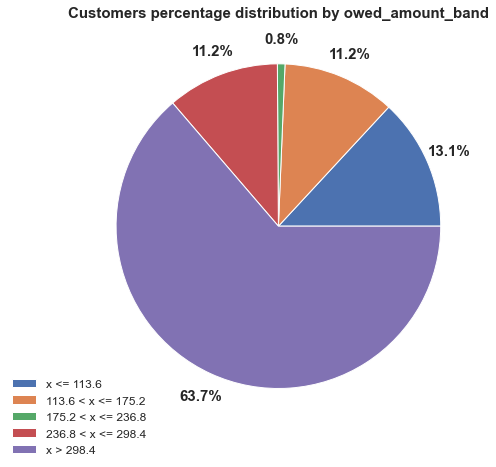

In [52]:
owed_amount_ticks = ['x <= 113.6', '113.6 < x <= 175.2', '175.2 < x <= 236.8', '236.8 < x <= 298.4', 'x > 298.4']
order = list(np.linspace(0,4,5))
plot_pie(df_train, 'owed_amount_band', owed_amount_ticks, order=order, pct=1.15, legend_pos=(0.2,0.15))

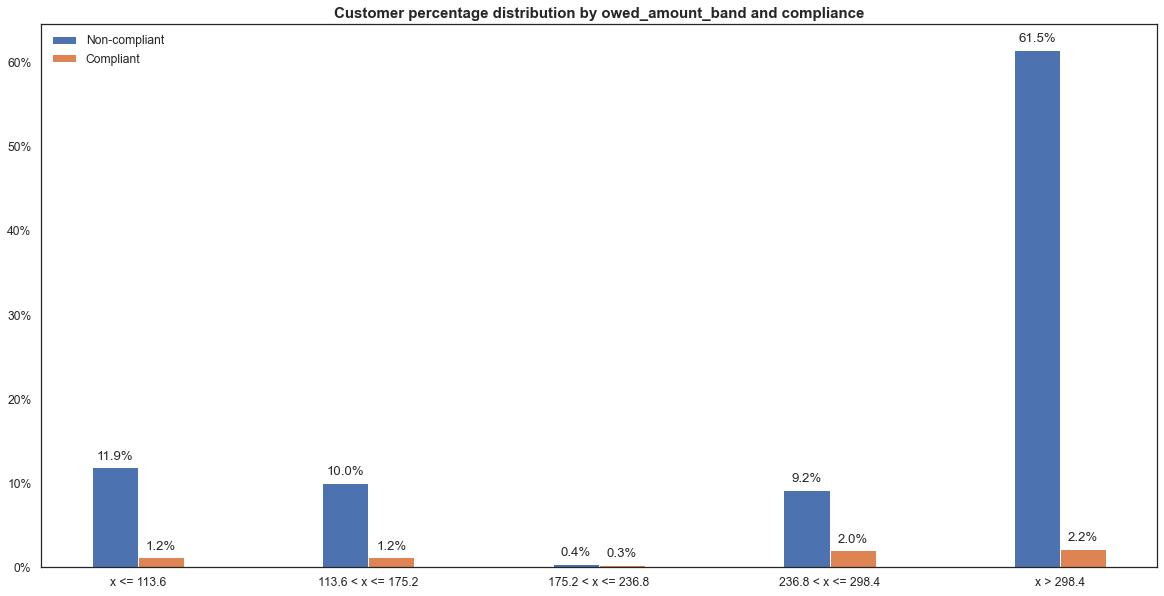

In [53]:
plot_percent_category(df_train, 'owed_amount_band', order, xticks=owed_amount_ticks)

In [54]:
df_train[df_train['compliance'] == 1]['owed_amount_band'].value_counts().sort_index()

0    1164
1    1160
2     321
3    1944
4    2151
Name: owed_amount_band, dtype: int64

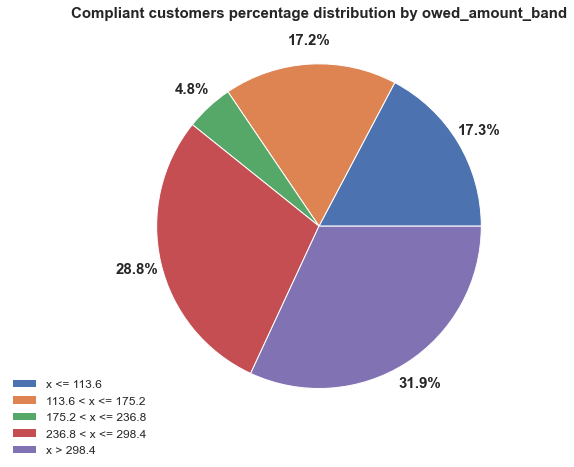

In [55]:
plot_pie(df_train, 'owed_amount_band', owed_amount_ticks, compliance=True, order=order, pct=1.15, legend_pos=(0.1,0.15))

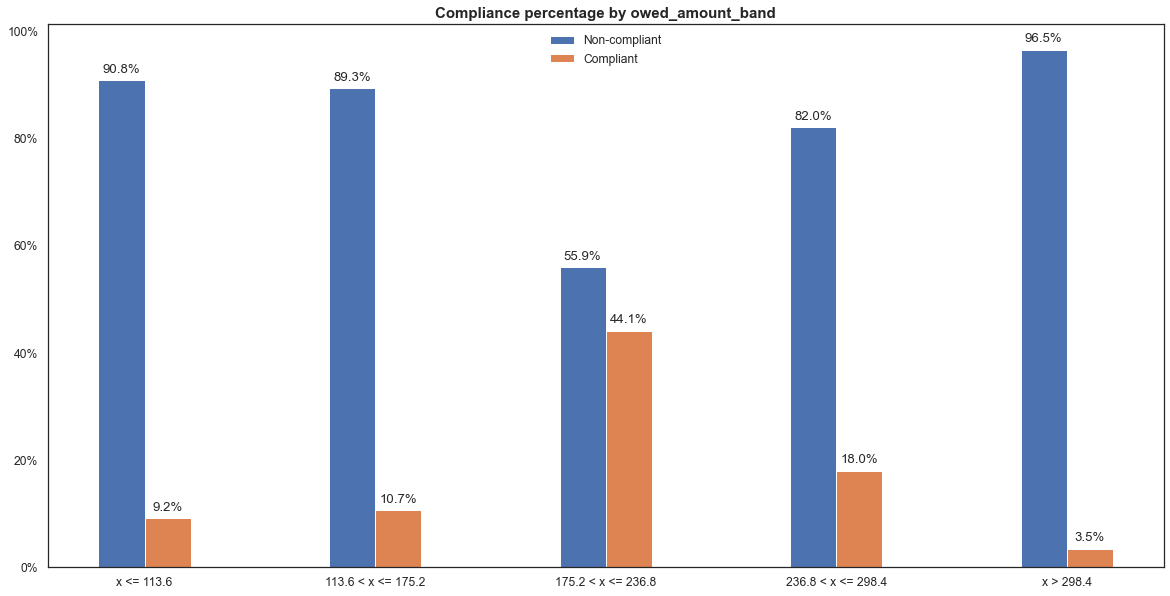

In [56]:
plot_percent_category(df_train, 'owed_amount_band', order, xticks=owed_amount_ticks, compliance=True, legend_loc=9)

### Observations:
* It seems that people that owes an amount between 175.2 and 236.8 have a higher compliance ratio, but it corresponds to only 0.8% of all issued people

## 2.2 Agency Name <a class='anchor' id='2.2'></a>

In [57]:
df_train['agency_name'].value_counts().sort_index().index

Index(['Buildings, Safety Engineering & Env Department',
       'Department of Public Works', 'Detroit Police Department',
       'Health Department'],
      dtype='object')

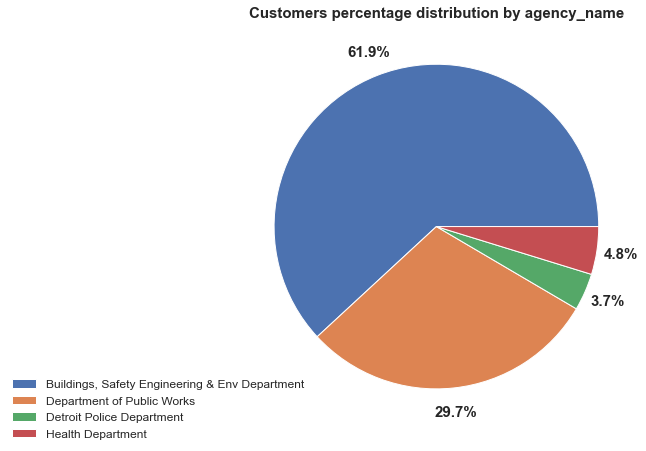

In [58]:
agency_ticks = list(df_train['agency_name'].value_counts().sort_index().index)
plot_pie(df_train, 'agency_name', agency_ticks, order=agency_ticks, pct=1.15, legend_pos=(0.2,0.15))

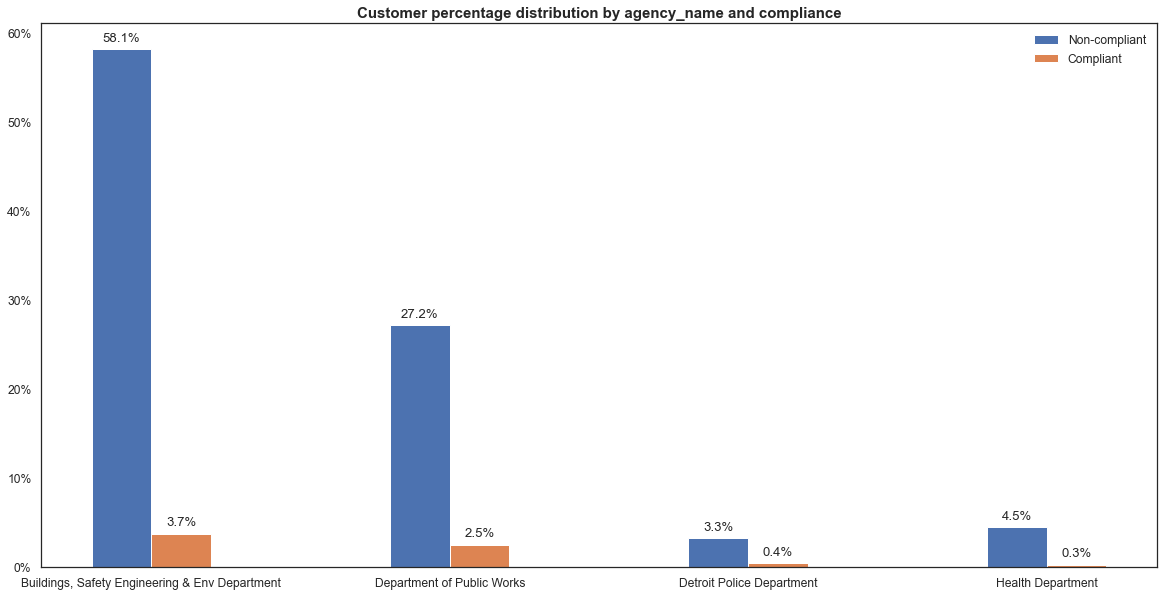

In [59]:
plot_percent_category(df_train, 'agency_name', agency_ticks, xticks=agency_ticks)

In [60]:
df_train[df_train['compliance'] == 1]['agency_name'].value_counts().sort_index()

Buildings, Safety Engineering & Env Department    3627
Department of Public Works                        2429
Detroit Police Department                          431
Health Department                                  253
Name: agency_name, dtype: int64

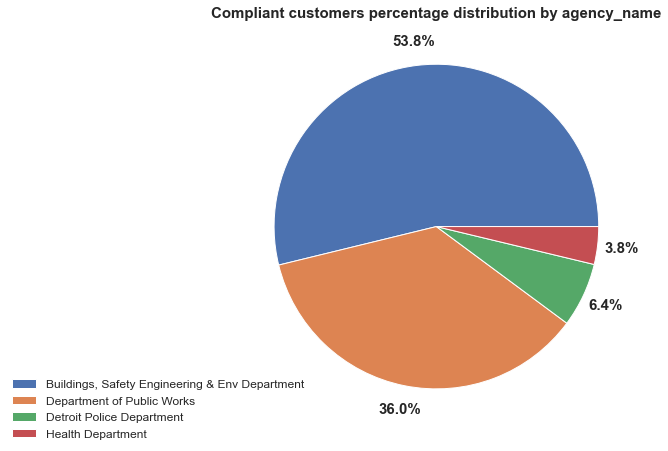

In [61]:
plot_pie(df_train, 'agency_name', agency_ticks, compliance=True, order=agency_ticks, pct=1.15, legend_pos=(0.2,0.15))

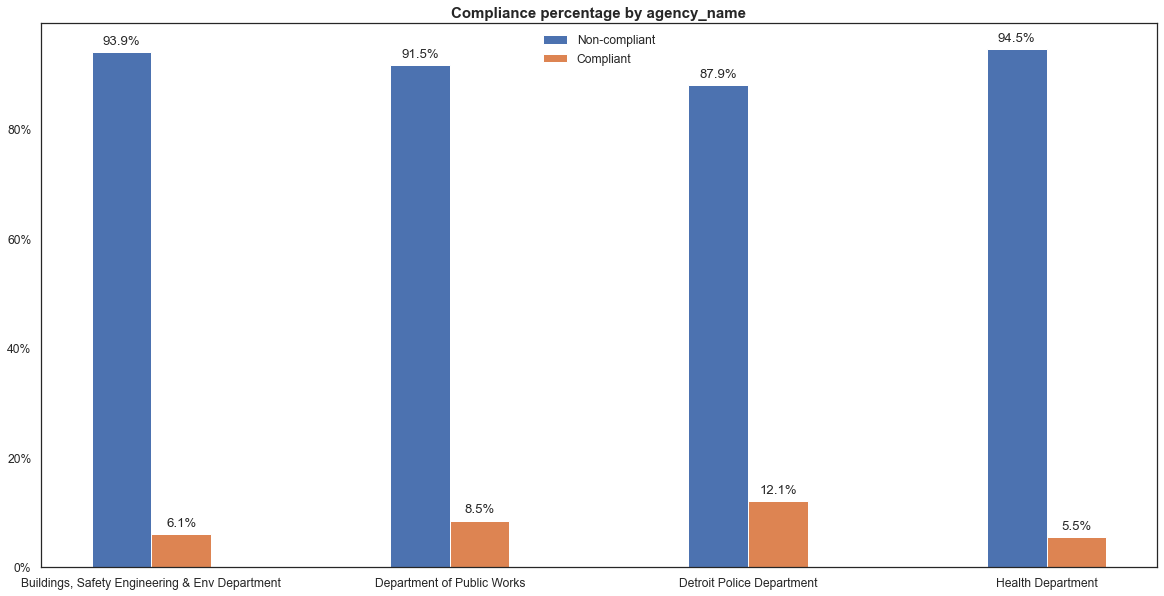

In [62]:
plot_percent_category(df_train, 'agency_name', agency_ticks, xticks=agency_ticks, compliance=True, legend_loc=9)

### Observations:
* Tickets issued by the Detroit Police Department have higher compliance ratio

## 2.3 Disposition <a class='anchor' id='2.3'></a>

In [63]:
df_train['disposition'].value_counts()

Responsible by Default          83817
Responsible by Admission         7758
Responsible by Determination     5170
Name: disposition, dtype: int64

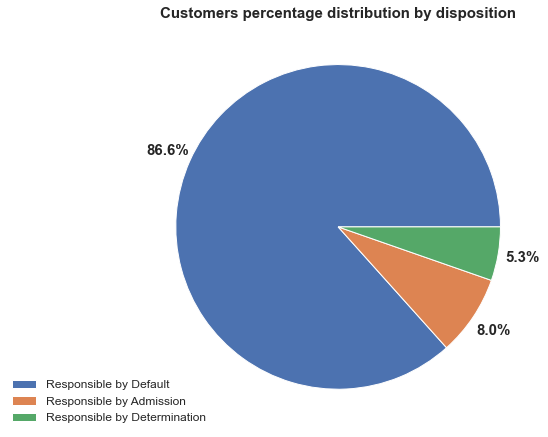

In [64]:
disposition_ticks = list(df_train['disposition'].value_counts().index)
plot_pie(df_train, 'disposition', disposition_ticks, order=disposition_ticks, pct=1.15, legend_pos=(0.2,0.15))

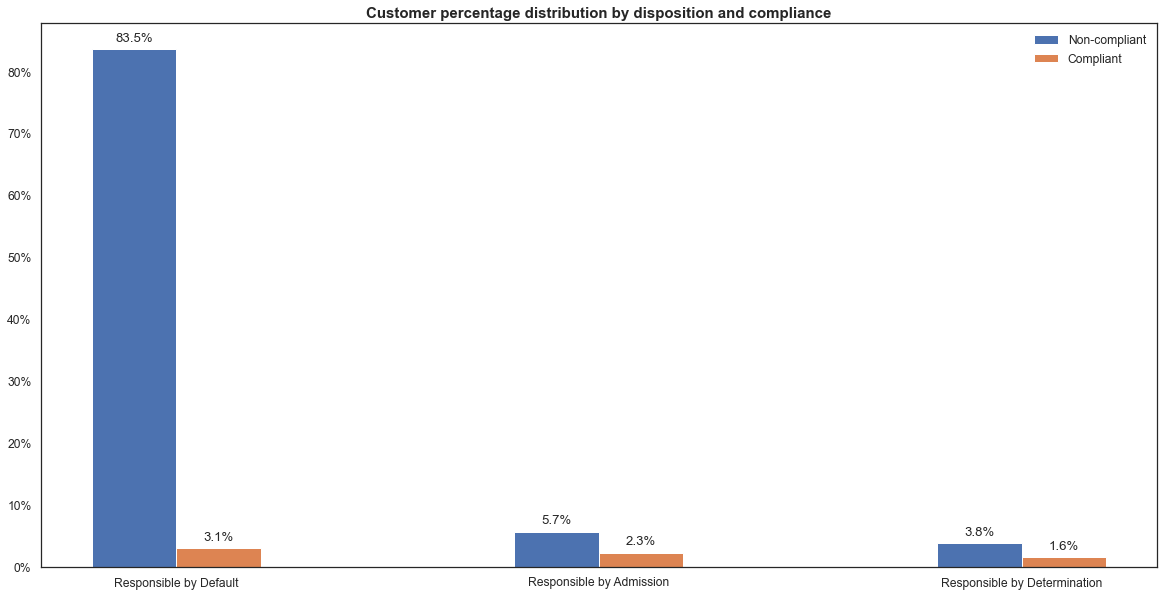

In [65]:
plot_percent_category(df_train, 'disposition', disposition_ticks, xticks=disposition_ticks)

In [66]:
df_train[df_train['compliance'] == 1]['disposition'].value_counts().sort_index()

Responsible by Admission        2242
Responsible by Default          2996
Responsible by Determination    1502
Name: disposition, dtype: int64

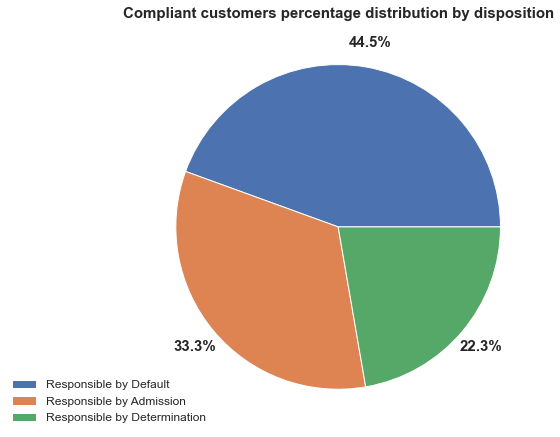

In [67]:
plot_pie(df_train, 'disposition', disposition_ticks, compliance=True, order=disposition_ticks, pct=1.15, legend_pos=(0.2,0.15))

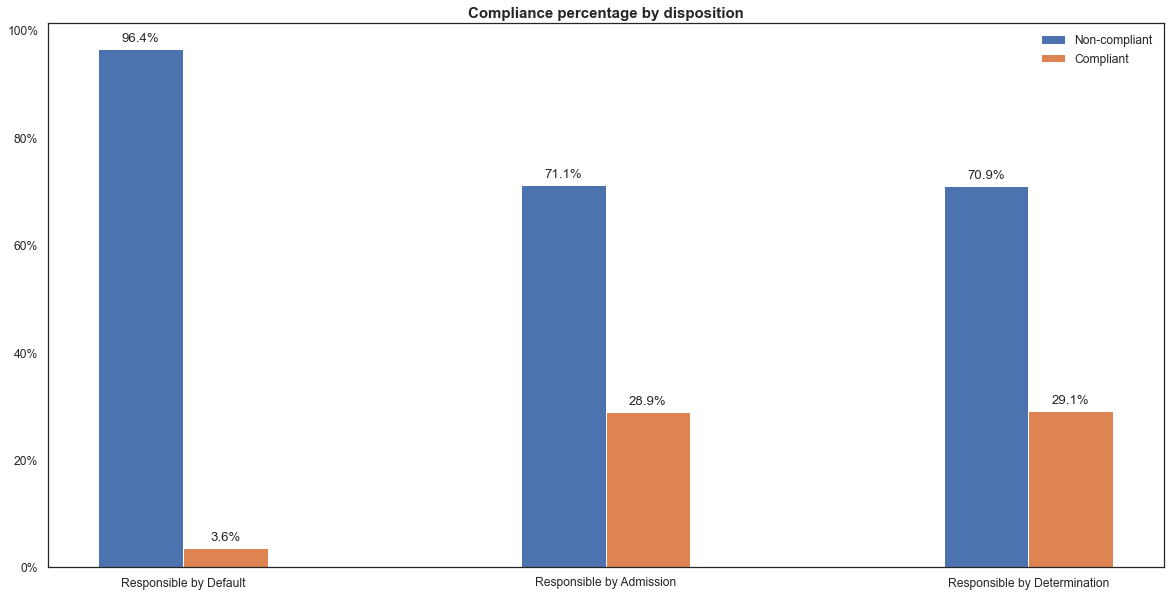

In [68]:
plot_percent_category(df_train, 'disposition', disposition_ticks, xticks=disposition_ticks, compliance=True)

### Observations:
* People that are judged as Responsible by Default have lower compliance ratio than the other types, but 86.6% percent of all tickets are issued in this type

## 2.4 Ticket Issued Month <a class='anchor' id='2.4'></a>

In [69]:
df_train['ticket_issued_month'].value_counts().sort_index()

01    7900
02    8732
03    9207
04    7744
05    8149
06    8419
07    7785
08    8857
09    9329
10    9267
11    6234
12    5122
Name: ticket_issued_month, dtype: int64

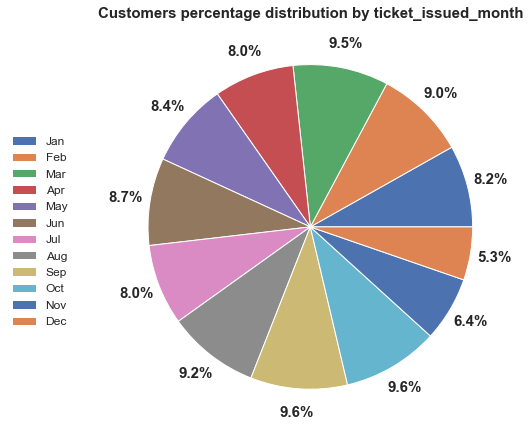

In [70]:
month_ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
order = list(df_train['ticket_issued_month'].value_counts().sort_index().index)
plot_pie(df_train, 'ticket_issued_month', month_ticks, order=order, pct=1.15, legend_pos=(-0.07,0.75))

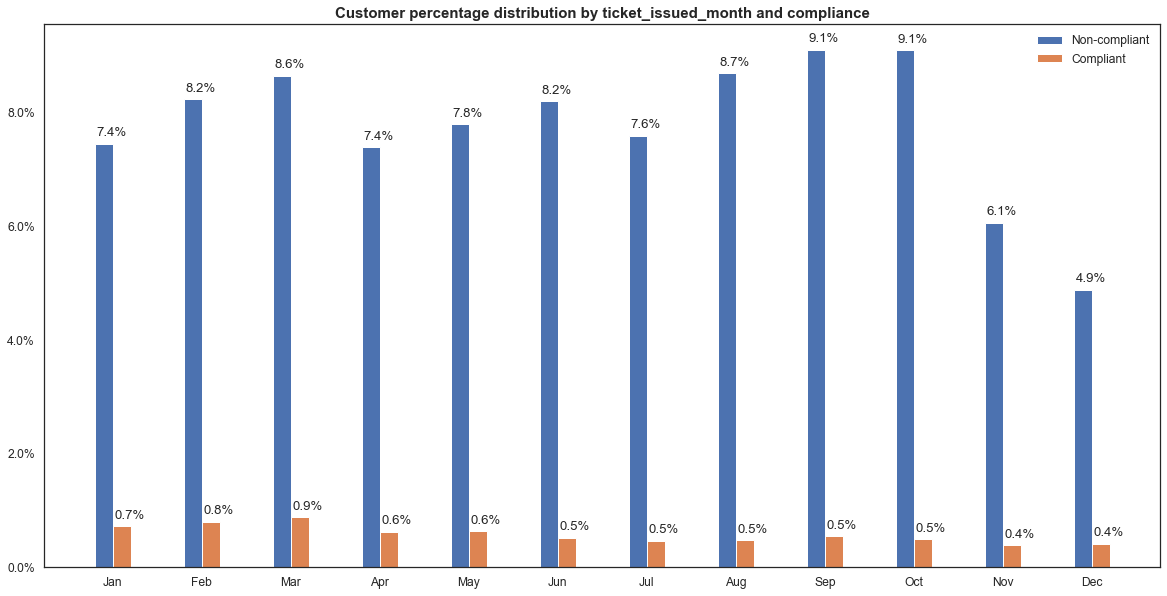

In [71]:
plot_percent_category(df_train, 'ticket_issued_month', order, xticks=month_ticks, xspace=8)

In [72]:
df_train[df_train['compliance'] == 1]['ticket_issued_month'].value_counts().sort_index()

01    698
02    778
03    851
04    602
05    616
06    499
07    449
08    463
09    529
10    477
11    377
12    401
Name: ticket_issued_month, dtype: int64

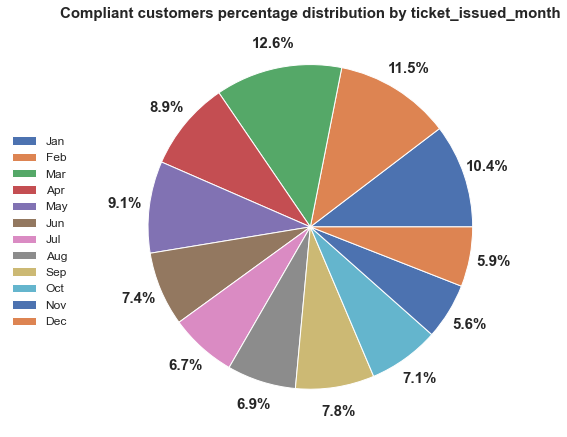

In [73]:
plot_pie(df_train, 'ticket_issued_month', month_ticks, compliance=True, order=order, pct=1.15, legend_pos=(-0.07,0.75))

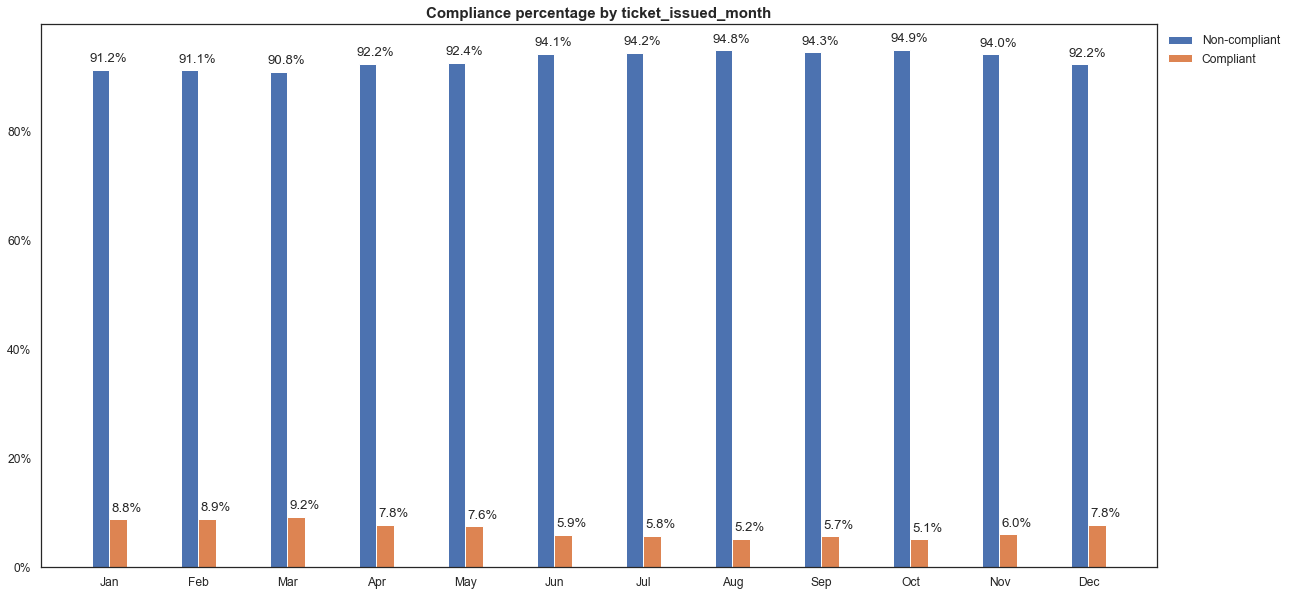

In [74]:
plot_percent_category(df_train, 'ticket_issued_month', order, xticks=month_ticks, compliance=True, xspace=8, legend_pos=(1,1))

### Observations:
* It looks like there is an average compliance ratio in months from the first semester than the second one

## 2.5 Ticket Issued Semester <a class='anchor' id='2.5'></a>

In [75]:
df_train['ticket_issued_semester'].value_counts()

1    50151
2    46594
Name: ticket_issued_semester, dtype: int64

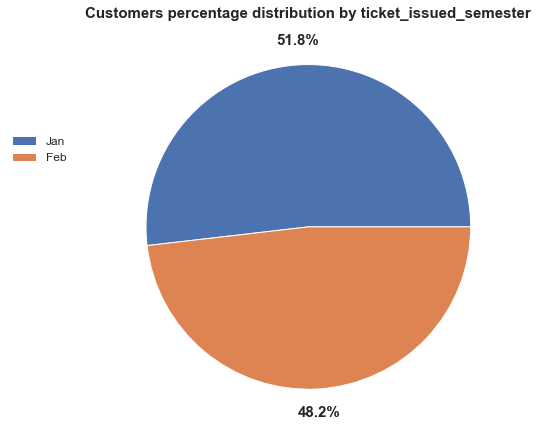

In [76]:
order = list(df_train['ticket_issued_semester'].value_counts().sort_index().index)
plot_pie(df_train, 'ticket_issued_semester', month_ticks, order=order, pct=1.15, legend_pos=(-0.07,0.75))

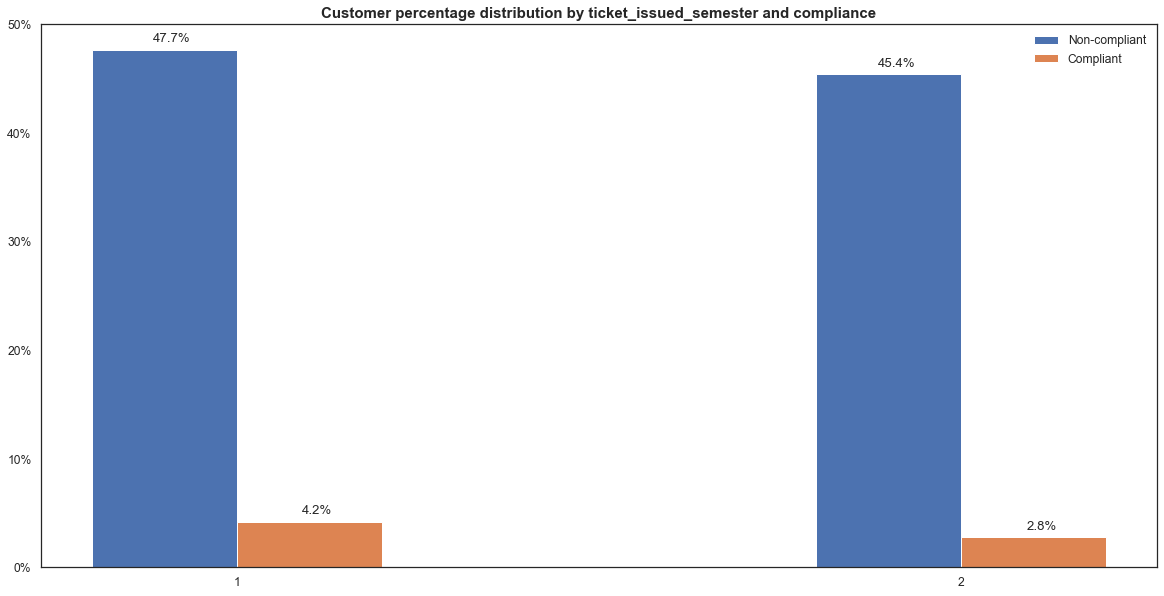

In [77]:
plot_percent_category(df_train, 'ticket_issued_semester', order, xticks=order, xspace=8)

In [78]:
df_train[df_train['compliance'] == 1]['ticket_issued_semester'].value_counts().sort_index()

1    4044
2    2696
Name: ticket_issued_semester, dtype: int64

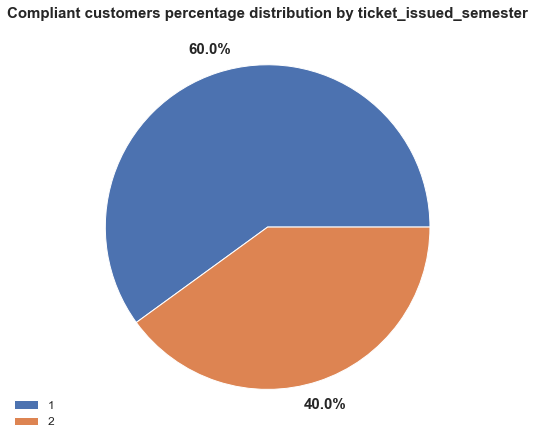

In [79]:
plot_pie(df_train, 'ticket_issued_semester', order, compliance=True, order=order, pct=1.15, legend_pos=(0,0.1))

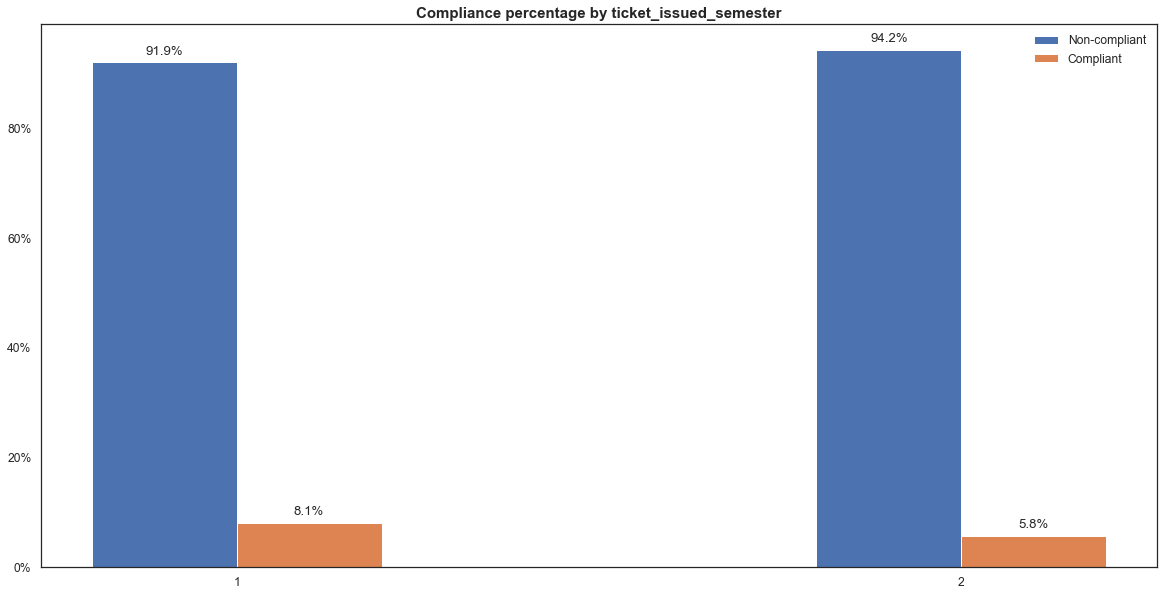

In [80]:
plot_percent_category(df_train, 'ticket_issued_semester', order, xticks=order, compliance=True)

### Observations:
* The average compliance ratio is higher in tickets issued in the first semester of the year

## 2.6 Hearing Month <a class='anchor' id='2.6'></a>

In [81]:
df_train['hearing_month'].value_counts().sort_index()

01     5388
02     6689
03     9312
04    11927
05     8580
06     7449
07     7369
08     8254
09     6856
10     8447
11     6961
12     9513
Name: hearing_month, dtype: int64

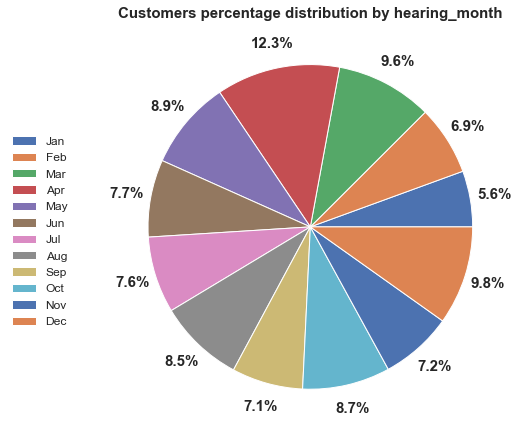

In [82]:
month_ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
order = list(df_train['hearing_month'].value_counts().sort_index().index)
plot_pie(df_train, 'hearing_month', month_ticks, order=order, pct=1.15, legend_pos=(-0.07,0.75))

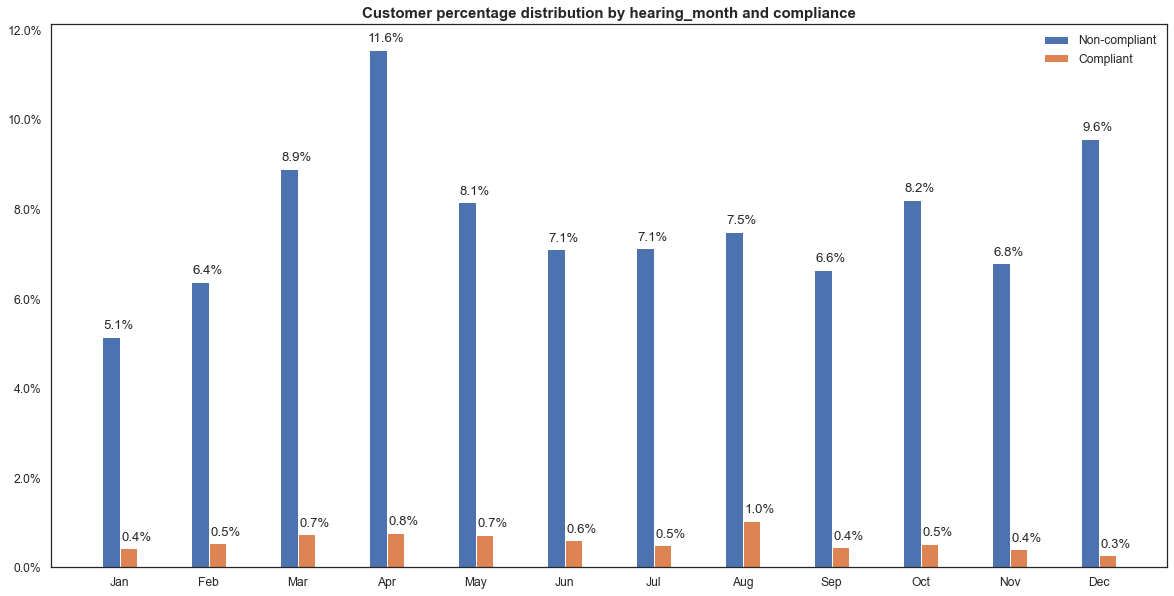

In [83]:
plot_percent_category(df_train, 'hearing_month', order, xticks=month_ticks, xspace=8)

In [84]:
df_train[df_train['compliance'] == 1]['hearing_month'].value_counts().sort_index()

01     407
02     522
03     709
04     746
05     698
06     580
07     477
08    1010
09     432
10     511
11     393
12     255
Name: hearing_month, dtype: int64

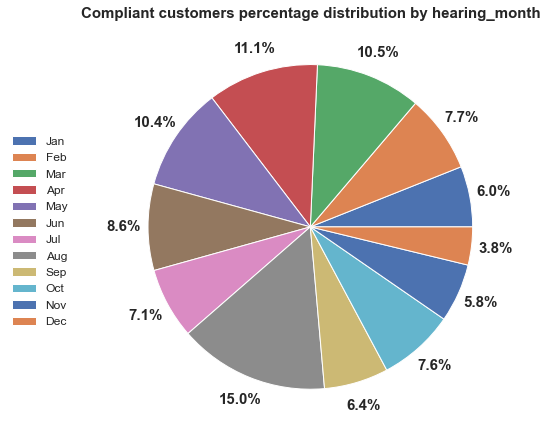

In [85]:
plot_pie(df_train, 'hearing_month', month_ticks, compliance=True, order=order, pct=1.15, legend_pos=(-0.07,0.75))

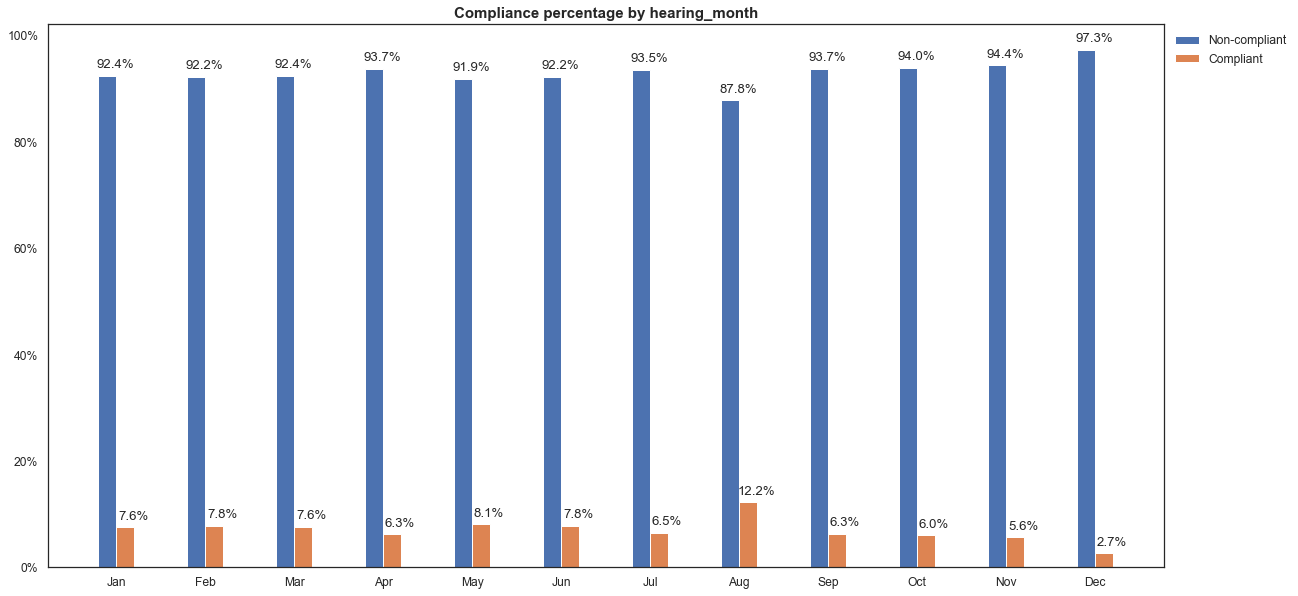

In [86]:
plot_percent_category(df_train, 'hearing_month', order, xticks=month_ticks, compliance=True, xspace=8, legend_pos=(1,1))

### Observations:
* There is not much difference between the compliance ratio of people that have different hearing months

# 3. Predictive Model <a class='anchor' id='3.'></a>

Since our goal is to predict the probability of a person with determined feature values is going to pay the blight ticket on time (be compliant (compliance = 1)), having a set of data with the labeled values to train our models, we are perfoming a Supervised Learning task of Classification. With this in mind, we can narrow our model choice to some fewer options presented below. The score parameter used to evaluate the models is ROC AUC score.
* Logistic Regression 
* SVC
* Linear SVC
* Decision Tree
* Random Forest
* KNN
* Naive Bayes
* Perceptron
* Stochastic Gradient Decent

## 3.1 Data Preprocessing and Feature Selection <a class='anchor' id='3.1'></a>

In [ ]:
def transform(le, data_list):
    """
    This will transform the data_list to id list where the new values get assigned to Unknown class
    :param data_list:
    :return:
    """
    new_data_list = list(data_list)
    for unique_item in np.unique(data_list):
        if unique_item not in le.classes_:
            new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

    return le.transform(new_data_list)

In [ ]:
def transform_categorical_features(df, columns):
    cate_features = list(df.select_dtypes(include=['object', 'category']).columns)
    transform_features = [column for column in columns if column in cate_features]

    for cate_col in transform_features:
        try:
            le = LabelEncoder().fit(list(df[cate_col].unique()) + ['Unknown'])
            df[cate_col] = transform(le, df[cate_col])
        except:
            continue
    
    return df

In [87]:
df_train.describe(include=['O'])

,agency_name,inspector_name,violator_name,violation_street_name,mailing_address_str_name,city,state,zip_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,payment_date,payment_status,compliance_detail,ticket_issued_year,ticket_issued_month,hearing_year,hearing_month,payment_year,payment_month
count,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,22810,96745,96745,96745,96745,96745,96745,22810,22810
unique,4,156,54958,294,8258,1,1,34,1,49309,5667,27,182,3,2164,3,6,9,12,10,12,13,12
top,"Buildings, Safety Engineering & Env Department","Morris, John","APARTMENTS, CARLTON",Rare,PO BOX,Detroit,MI,48227,USA,2008-01-22 09:00:00,2005-12-20 09:00:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,2007-05-25 00:00:00,NO PAYMENT APPLIED,non-compliant by no payment,2006,09,2006,04,2007,06
freq,59860,8023,102,32363,1939,96745,96745,7219,96745,49,395,41242,41242,83817,93,73935,79062,18071,9329,19758,11927,3693,2767


In [88]:
df_backup = df_train.copy()
cate_features = list(df_train.select_dtypes(include=['object', 'category']).columns)
columns = ['agency_name', 'violation_street_name', 'zip_code', 'ticket_issued_month', 
           'ticket_issued_semester', 'violation_code', 'disposition']

for cate_col in columns:
    try:
        le = LabelEncoder().fit(list(df_train[cate_col].unique()) + ['Unknown'])
        df_train[cate_col] = transform(le, df_train[cate_col])
        df_train[cate_col] = df_train[cate_col].astype('category')
        jb.dump(le,"model/le_{}_blight_ticket.pk;.z".format(cate_col))
    except:
        continue

df_train.head()

<ipython-input-3-74ef0c7f52c3>:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if unique_item not in le.classes_:


,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,compliance_detail,compliance,owed_amount,owed_amount_band,ticket_issued_year,ticket_issued_month,ticket_issued_semester,hearing_year,hearing_month,payment_year,payment_month
ticket_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27586,0,"Williams, Darrin","Michigan, Covenant House",4311.0,61,2959.0,Martin Luther King,Detroit,MI,7,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,26,Failed To Secure Permit For Lawful Use Of Buil...,2,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,compliant by late payment within 1 month,1.0,855.0,4,2004,3,2,2005,05,2005,06
18735,0,"Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,198,8228.0,Mt. Elliott,Detroit,MI,10,USA,2004-06-16 12:30:00,2005-02-22 15:00:00,26,Noncompliance/Grant Condition/BZA/BSE,1,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,140.0,1,2004,5,2,2005,02,NaN,NaN
18733,0,"Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,198,8228.0,Mt. Elliott,Detroit,MI,10,USA,2004-06-16 12:25:00,2005-02-22 15:00:00,26,Noncompliance/Grant Condition/BZA/BSE,1,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,140.0,1,2004,5,2,2005,02,NaN,NaN
28204,0,"Williams, Darrin","Inc, Nanno",15307.0,242,1537.0,E. Seven Mile,Detroit,MI,4,USA,2004-07-12 13:30:00,2005-05-31 13:30:00,26,Failed To Secure Permit For Lawful Use Of Buil...,1,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,855.0,4,2004,6,2,2005,05,NaN,NaN
18743,0,"Williams, Darrin","Gardner Resale, GAR",9100.0,269,91.0,Van Dyke,Detroit,MI,12,USA,2004-07-28 12:15:00,2005-02-22 15:00:00,26,Failed To Secure Permit For Lawful Use Of Buil...,1,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,855.0,4,2004,6,2,2005,02,NaN,NaN


In [89]:
df_train.describe()

,violation_street_number,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance,owed_amount,owed_amount_band
count,9.674500e+04,9.674500e+04,96745.000000,96745.0,96745.0,96745.000000,96745.000000,96745.0,96745.000000,96745.000000,96745.000000,96745.000000,96745.000000,96745.000000
mean,1.031852e+04,7.865159e+03,324.110962,20.0,10.0,30.609737,0.139418,0.0,384.720699,57.096167,327.485197,0.069668,384.581281,3.011525
std,4.626965e+04,2.284441e+04,601.721250,0.0,0.0,60.407631,2.659109,0.0,661.510687,163.511476,666.774246,0.254587,661.483612,1.507863
min,0.000000e+00,1.000000e+00,25.000000,20.0,10.0,0.000000,0.000000,0.0,55.000000,0.000000,-1575.000000,0.000000,52.000000,0.000000
25%,4.314000e+03,8.320000e+02,200.000000,20.0,10.0,10.000000,0.000000,0.0,230.000000,0.000000,85.000000,0.000000,230.000000,2.000000
50%,9.534000e+03,2.668000e+03,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000,305.000000,4.000000
75%,1.542500e+04,1.354800e+04,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000,305.000000,4.000000
max,1.415411e+07,3.511219e+06,10000.000000,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,11030.000000,11030.000000,1.000000,11030.000000,4.000000


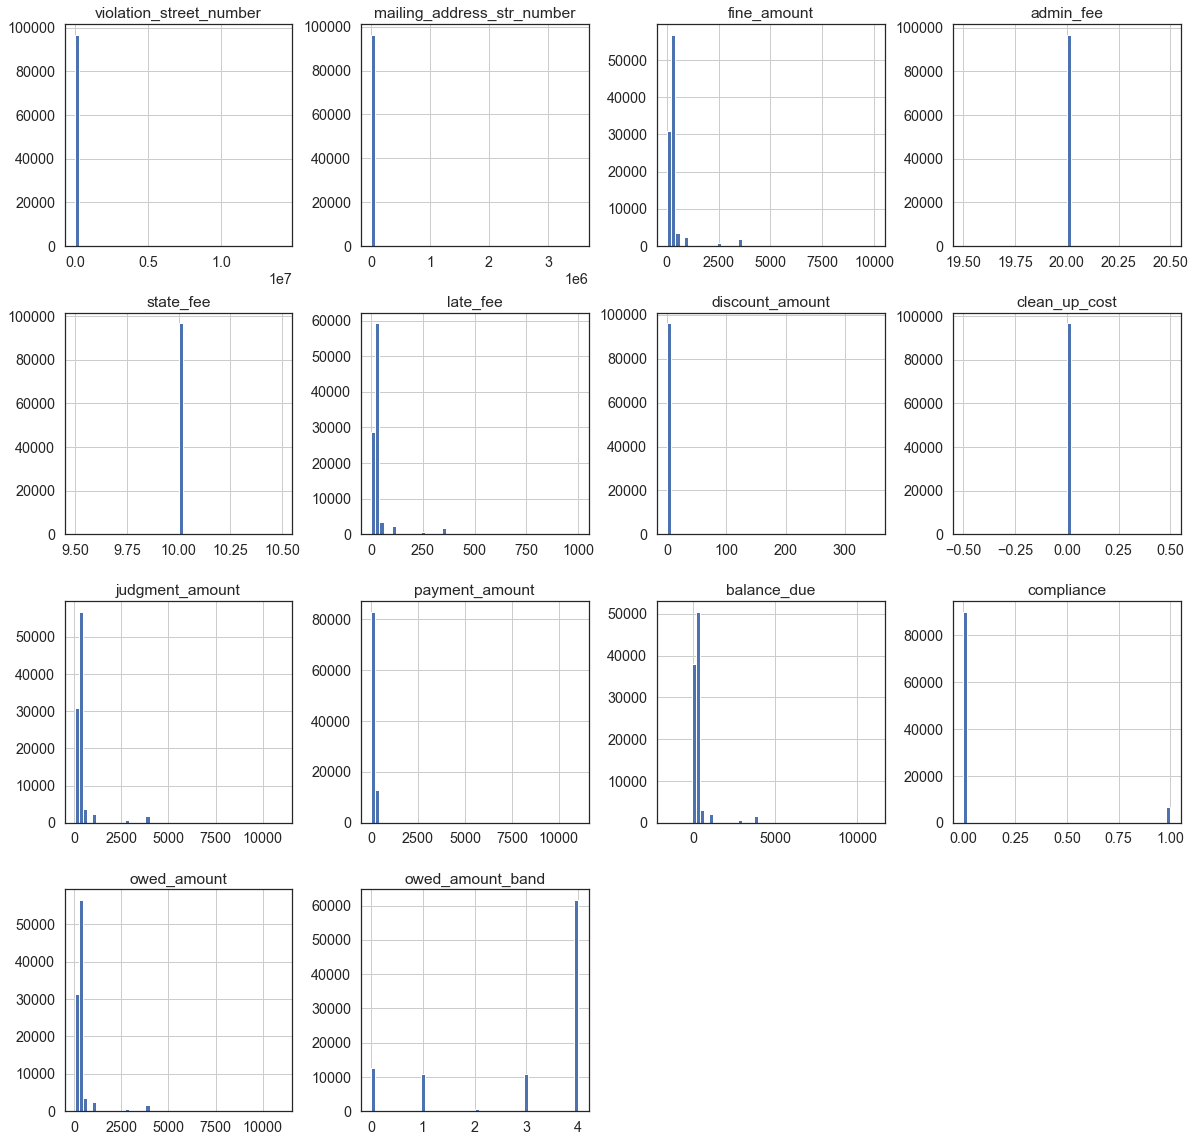

In [90]:
sns.set(style='white',font_scale=1.3, rc={'figure.figsize':(20,20)})
ax=df_train.hist(bins=50)

In [91]:
scaler = MinMaxScaler()
df_train['owed_amount'] = np.log1p(df_train['owed_amount'])
df_train['owed_amount'] = scaler.fit_transform(df_train[['owed_amount']].values)

In [92]:
cols = {}
col_list = [['owed_amount'],
            ['owed_amount_band'],
            ['owed_amount', 'agency_name'],
            ['owed_amount', 'violation_street_name'],
            ['owed_amount', 'zip_code'],
            ['owed_amount', 'ticket_issued_month'],
            ['owed_amount', 'ticket_issued_semester'],
            ['owed_amount', 'violation_code'],
            ['owed_amount', 'disposition']]

for col_num in range(len(col_list)):
    cols[col_num+1] = col_list[col_num]

## 3.2 Models <a class='anchor' id='3.2'></a>

In [95]:
models = dict()
models['logistic_regression'] = LogisticRegression(random_state=42)
models['linear_svc'] = LinearSVC(random_state=42)
models['decision_tree'] = DecisionTreeClassifier(random_state=42)
models['random_forest'] = RandomForestClassifier(random_state=42) 
models['knn'] = KNeighborsClassifier(n_neighbors=3)
models['naive_bayes'] = GaussianNB()
models['perceptron'] = Perceptron(random_state=42)
models['sgdc'] = SGDClassifier(random_state=42)

In [96]:
def blight_model(df, model, columns = ['owed_amount'], cross_val=False):    
    # Prepare the datasets
    X = df[columns]
    y = df['compliance']

    if cross_val == False:
        # Calculate the roc_auc_score
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:,1]

        auc_score = roc_auc_score(y_test, y_pred)
    else:
        clf = model
        auc_score = np.mean(cross_val_score(clf, X, y, scoring='roc_auc', cv=3))
        
    return auc_score

### Logistic Regression

In [97]:
# Start counting time
start = time.perf_counter()

logistic_scores = {}
for key, value in cols.items():
    logistic_scores[key] = blight_model(df_train, models['logistic_regression'], columns=value, cross_val=True)

# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('Logistic Regression', run))

Computational runtime of Logistic Regression algorithm: 2.31 seconds


In [98]:
logistic_scores

{1: 0.6529417371122359,
 2: 0.6480565443783344,
 3: 0.6434076548681176,
 4: 0.6176136070370983,
 5: 0.6268466696147253,
 6: 0.6109457835363926,
 7: 0.6529417371122359,
 8: 0.654303191259634,
 9: 0.5329797575523036}

### Linear SVC Regression

In [99]:
# Start counting time
start = time.perf_counter()

linear_svc_scores = {}
for key, value in cols.items():
    linear_svc_scores[key] = blight_model(df_train, model=models['linear_svc'], columns=value, cross_val=True)

# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('Linear SVC', run))

C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge

Computational runtime of Linear SVC algorithm: 33.73 seconds


In [100]:
linear_svc_scores

{1: 0.6529417371122359,
 2: 0.6480565443783344,
 3: 0.6512575143519558,
 4: 0.5473701251331008,
 5: 0.5929894725753774,
 6: 0.6100185601095746,
 7: 0.6529417371122359,
 8: 0.6548881163857453,
 9: 0.5331321904888444}

### Decision Tree

In [101]:
# Start counting time
start = time.perf_counter()

dt_scores = {}
for key, value in cols.items():
    dt_scores[key] = blight_model(df_train, model=models['decision_tree'], columns=value, cross_val=True)

# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('Decision Tree', run))

Computational runtime of Decision Tree algorithm: 1.10 seconds


In [102]:
dt_scores

{1: 0.7481694901941549,
 2: 0.6967858719376993,
 3: 0.7431439829219055,
 4: 0.6698378769505396,
 5: 0.730188995694756,
 6: 0.7249627923049192,
 7: 0.7481694901941549,
 8: 0.7529706303655005,
 9: 0.7851392880556866}

### Random Forest

In [103]:
# Start counting time
start = time.perf_counter()

rf_scores = {}
for key, value in cols.items():
    rf_scores[key] = blight_model(df_train, model=models['random_forest'], columns=value, cross_val=True)

# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('Random Forest', run))

Computational runtime of Random Forest algorithm: 35.23 seconds


In [104]:
rf_scores

{1: 0.7482550959032701,
 2: 0.6967858719376993,
 3: 0.7438203353092593,
 4: 0.698170796803173,
 5: 0.7366966235552352,
 6: 0.7307290362440115,
 7: 0.7482550959032701,
 8: 0.756139365850852,
 9: 0.7865634529809339}

### KNN

In [105]:
# Start counting time
start = time.perf_counter()

knn_scores = {}
for key, value in cols.items():
    knn_scores[key] = blight_model(df_train, model=models['knn'], columns=value, cross_val=True)
    
# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('KNN', run))

Computational runtime of KNN algorithm: 143.60 seconds


In [106]:
knn_scores

{1: 0.6106395307345452,
 2: 0.4688262798088862,
 3: 0.6309887917966607,
 4: 0.6138245102299267,
 5: 0.6204985242278218,
 6: 0.6195304269949565,
 7: 0.6106395307345452,
 8: 0.6200219260026902,
 9: 0.6545635262081998}

### Naive Bayes

In [107]:
# Start counting time
start = time.perf_counter()

naive_bayes_scores = {}
for key, value in cols.items():
    naive_bayes_scores[key] = blight_model(df_train, model=models['naive_bayes'], columns=value, cross_val=True)

# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('Naive Bayes', run))

Computational runtime of Naive Bayes algorithm: 1.99 seconds


In [108]:
naive_bayes_scores

{1: 0.6454950438598487,
 2: 0.6480565443783344,
 3: 0.6349338231552373,
 4: 0.6111087877902419,
 5: 0.6343423913479663,
 6: 0.6037148218466931,
 7: 0.6454950438598487,
 8: 0.6461612884914408,
 9: 0.7650364221175314}

### Perceptron

In [109]:
# Start counting time
start = time.perf_counter()

perceptron_scores = {}
for key, value in cols.items():
    perceptron_scores[key] = blight_model(df_train, model=models['perceptron'], columns=value, cross_val=True)

# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('Perceptron', run))

Computational runtime of Perceptron algorithm: 3.07 seconds


In [110]:
perceptron_scores

{1: 0.6529417371122359,
 2: 0.6480565443783344,
 3: 0.5981188253842429,
 4: 0.4919223788277533,
 5: 0.5169836911281253,
 6: 0.57285204668453,
 7: 0.6529417371122359,
 8: 0.6244499837368295,
 9: 0.6529417371122359}

### SGDC

In [111]:
# Start counting time
start = time.perf_counter()

sgdc_scores = {}
for key, value in cols.items():
    sgdc_scores[key] = blight_model(df_train, model=models['sgdc'], columns=value, cross_val=True)

# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('SGDC', run))

Computational runtime of SGDC algorithm: 7.09 seconds


In [112]:
sgdc_scores

{1: 0.6529417371122359,
 2: 0.4798145727694642,
 3: 0.5307576046509391,
 4: 0.5740905402851529,
 5: 0.5275053306072852,
 6: 0.5699561586619603,
 7: 0.6529417371122359,
 8: 0.5663690018058188,
 9: 0.5158589139177471}

### Model Comparison

In [113]:
cols

{1: ['owed_amount'],
 2: ['owed_amount_band'],
 3: ['owed_amount', 'agency_name'],
 4: ['owed_amount', 'violation_street_name'],
 5: ['owed_amount', 'zip_code'],
 6: ['owed_amount', 'ticket_issued_month'],
 7: ['owed_amount', 'ticket_issued_semester'],
 8: ['owed_amount', 'violation_code'],
 9: ['owed_amount', 'disposition']}

In [114]:
index=['Logistic Regression', 'Linear SVC', 'Decision Tree', 
       'Random Forest', 'KNN', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Decent']

df_models = pd.DataFrame([logistic_scores, linear_svc_scores, dt_scores,
              rf_scores, knn_scores, naive_bayes_scores, perceptron_scores, sgdc_scores])
df_models.index = index
df_models['max'] = df_models[df_models.columns].max(axis=1)
df_models = df_models.sort_values(by='max', ascending=False)

column_names = ['owed_amount', 'owed_amount_band'] + [lista[1] for lista in list(cols.values())[2:]] + ['max']
df_models.columns = column_names
df_models

,owed_amount,owed_amount_band,agency_name,violation_street_name,zip_code,ticket_issued_month,ticket_issued_semester,violation_code,disposition,max
Random Forest,0.748255,0.696786,0.743820,0.698171,0.736697,0.730729,0.748255,0.756139,0.786563,0.786563
Decision Tree,0.748169,0.696786,0.743144,0.669838,0.730189,0.724963,0.748169,0.752971,0.785139,0.785139
Naive Bayes,0.645495,0.648057,0.634934,0.611109,0.634342,0.603715,0.645495,0.646161,0.765036,0.765036
Linear SVC,0.652942,0.648057,0.651258,0.547370,0.592989,0.610019,0.652942,0.654888,0.533132,0.654888
KNN,0.610640,0.468826,0.630989,0.613825,0.620499,0.619530,0.610640,0.620022,0.654564,0.654564
Logistic Regression,0.652942,0.648057,0.643408,0.617614,0.626847,0.610946,0.652942,0.654303,0.532980,0.654303
Perceptron,0.652942,0.648057,0.598119,0.491922,0.516984,0.572852,0.652942,0.624450,0.652942,0.652942
Stochastic Gradient Decent,0.652942,0.479815,0.530758,0.574091,0.527505,0.569956,0.652942,0.566369,0.515859,0.652942


* The first column 'owed_amount' indicates the ROC AUC scores of each machine learning model trained with only the 'owed_amount' feature
* The 2nd~8th columns (feature named columns) indicates the ROC AUC scores of each machine learning model trained with the 'owed_amount' and the respective column name feature
* The max column indicates the maximum ROC AUC score achieve by each machine learning model

In [115]:
models_features_influences = df_models.apply(lambda x: x - df_models['owed_amount'])
models_features_influences.columns = column_names
models_features_influences

,owed_amount,owed_amount_band,agency_name,violation_street_name,zip_code,ticket_issued_month,ticket_issued_semester,violation_code,disposition,max
Random Forest,0.0,-0.051469,-0.004435,-0.050084,-0.011558,-0.017526,0.0,0.007884,0.038308,0.038308
Decision Tree,0.0,-0.051384,-0.005026,-0.078332,-0.017980,-0.023207,0.0,0.004801,0.036970,0.036970
Naive Bayes,0.0,0.002562,-0.010561,-0.034386,-0.011153,-0.041780,0.0,0.000666,0.119541,0.119541
Linear SVC,0.0,-0.004885,-0.001684,-0.105572,-0.059952,-0.042923,0.0,0.001946,-0.119810,0.001946
KNN,0.0,-0.141813,0.020349,0.003185,0.009859,0.008891,0.0,0.009382,0.043924,0.043924
Logistic Regression,0.0,-0.004885,-0.009534,-0.035328,-0.026095,-0.041996,0.0,0.001361,-0.119962,0.001361
Perceptron,0.0,-0.004885,-0.054823,-0.161019,-0.135958,-0.080090,0.0,-0.028492,0.000000,0.000000
Stochastic Gradient Decent,0.0,-0.173127,-0.122184,-0.078851,-0.125436,-0.082986,0.0,-0.086573,-0.137083,0.000000


The dataframe above shows how each feature influenced to the respective model in achieving its ROC AUC score. For the Random Forest model, the features below contributed to increase the ROC AUC score:
* ticket_issued_semester
* violation_code
* disposition

Analysing the dataframes above, the best choice of model is: <strong>Random Forest</strong>

I will add the features that most contributed to increase the ROC AUC score in comparison to the model executed with only the 'owed_amount' column.<br>
I will try different combinations of features and choose the one with best score.

In [116]:
columns = ['owed_amount', 'ticket_issued_semester', 'violation_code', 'disposition']
rf_score = blight_model(df_train, model=models['random_forest'], columns=columns, cross_val=True)
rf_score

0.7872087854978407

In [117]:
columns = ['owed_amount', 'ticket_issued_semester', 'disposition']
rf_score = blight_model(df_train, model=models['random_forest'], columns=columns, cross_val=True)
rf_score

0.7865798846563318

In [118]:
columns = ['owed_amount', 'violation_code', 'disposition']
rf_score = blight_model(df_train, model=models['random_forest'], columns=columns, cross_val=True)
rf_score

0.7876189682343141

In [119]:
columns = ['owed_amount', 'disposition']
rf_score = blight_model(df_train, model=models['random_forest'], columns=columns, cross_val=True)
rf_score

0.7865634529809339

Combining the features 'owed_amount', 'ticket_issued_semester', 'violation_code' and 'disposition', we were able to achieve the ROC AUC score of 0.7872.<br>
I will stick with these features and start tuning the Random Forest hyperparameters.

## 3.3 Hyperparameter Tuning <a class='anchor' id='3.3'></a>

#### Randomized Search CV

In [232]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


# Prepare the datasets
columns = ['owed_amount', 'ticket_issued_semester', 'violation_code', 'disposition']
X = df_train[columns]
y = df_train['compliance']
X_train, X_test, y_train, y_test = train_test_split(X, y)
    
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='roc_auc', n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

rf_random.best_params_

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [233]:
rf_random.best_score_

0.8021690178076328

#### Grid Search CV

In [234]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 4, 5],
    'n_estimators': [500, 1000, 1500]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='roc_auc', 
                          cv = 3, n_jobs = -1, verbose = 2, random_state=42)

grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 1500}

In [235]:
grid_search.best_score_

0.802237531763054

The grid_search algo had the best score, so I will save this model to use in the streamlit app

## 3.4 Save Model <a class='anchor' id='3.4'></a>

In [121]:
# Prepare the datasets
columns = ['owed_amount', 'ticket_issued_semester', 'violation_code', 'disposition']
X = df_train[columns]
y = df_train['compliance'] 

rf = RandomForestClassifier(bootstrap=True, max_depth=110, max_features='auto', min_samples_leaf=4, min_samples_split=3, 
                            n_estimators=1500)
rf.fit(X,y)

jb.dump(rf,"model/rf_blight_ticket.pk;.z")
jb.dump(scaler,"model/scaler_blight_ticket.pk;.z")

['model/scaler_blight_ticket.pk;.z']

# 4. Conclusion <a class='anchor' id='4.'></a>

## 4.1 Payment <a class='anchor' id='4.1'></a>

* Every year, an average amount of `$ 5,314,118.71` of blight tickets is issued
* Every year, an average amount of `$ 4,525,170.77` of the blight tickets is not paid, resulting in a yearly payment percetage of 14.72%
* The total pending payment value of blight tickets, until 2017, is `$ 31,682,555.40`
* Months that contains the highest accumulated amounts of payment: March to June
* Remainders or charges of late or possibly late tickets could be preferably be made from March to June, when 

## 4.2 Compliance <a class='anchor' id='4.2'></a>

* Percentage of compliant people: 6.97%
* Percentage of non-compliant people: 93.03%
* Almost 88% of the non-compliant cases are from people who didn't pay the blight ticket

## 4.3 Model <a class='anchor' id='4.3'></a>

* This is a supervised learning classification task
* A Random Forest Model was used to predict the probability of a person paying the blight ticket on time
* The features used to do the prediction were:
    * owed_amount: Sum of all fines and fees minus the discount amount
    * ticket_issued_semester: The semester when the blight ticket was issued
    * disposition: Judgement type
* Using the cross validation method, the model achieved a ROC AUC score of 0.791937